# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> APCOMP 295 Advanced Practical Data Science
## Exercise 5: Semantic Segmentation with Transfer Learning



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas


<hr style="height:2pt">

**Each assignment is graded out of 5 points.  The topic for this assignment is Semantic Segmentation with Transfer Learning.**

**Due:** 10/20/2020 10:15 AM EDT

**Submit:** We won't be re running your notebooks, please ensure output is visible in the notebook.

#### Learning Objectives

In this exercise you will cover the following topics:  
- Building data input pipelines using `tf.data`
- Build Semantic Segmentation model with a pretrained image classifier as base
- Using callbacks to manage model training paramaters

---

#### Imports

In [1]:
import os
import requests
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
from string import Template
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from keras.utils.layer_utils import count_params

from google.colab import auth
from google.cloud import storage

from sklearn.model_selection import train_test_split

#### Verify Setup

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells and record the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [2]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.3.0
keras version 2.4.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [3]:
!nvidia-smi

Mon Oct 19 22:46:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    34W /  70W |    227MiB / 15079MiB |      7%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Utils

Here are some util functions that will be helpful

In [4]:
def download_file(packet_url, base_path="", extract=False):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

def save_model(path="models",model_name="model01"):

  # Ensure path exists
  if not os.path.exists(path):
      os.mkdir(path)

  # Save the enitire model (structure + weights)
  model.save(os.path.join(path,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(path,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(path,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(path="models",model_name="model01"):
  model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
  return model_size

def evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
      # Save model
      save_model(model_name=model.name)
      model_size = get_model_size(model_name=model.name)

      # Save model history
      with open(os.path.join("models",model.name+"_train_history.json"), "w") as json_file:
          json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

      trainable_parameters = count_params(model.trainable_weights)
      non_trainable_parameters = count_params(model.non_trainable_weights)

      # Save model metrics
      metrics ={
          "trainable_parameters":trainable_parameters,
          "execution_time":execution_time,
          "loss":evaluation_results[0],
          "accuracy":evaluation_results[1],
          "model_size":model_size,
          "learning_rate":learning_rate,
          "batch_size":batch_size,
          "epochs":epochs,
          "optimizer":type(optimizer).__name__,
          "label_names": label_names,
          "name": model.name,
          "id": int(time.time())
      }
      with open(os.path.join("models",model.name+"_metrics.json"), "w") as json_file:
          json_file.write(json.dumps(metrics,cls=JsonEncoder))

## Question 1 : Setup & Concepts (1.0 Point)

#### a) Explain in your own words the difference between image classification and semantic segmentation

Needs to be 2-3 sentences at most.
 

##### **Submission:** 

Image classification is interested with determining what is in an imagee, and generally a classification model outputs probabilities that a given image contains different object types. Semantic segmentation, meanwhile, is interested in every single pixel in an image, that may contain multiple objects. Therefore, the output of a semantic segmentation model is a class for each pixel in an image.

#### b) How is this difference reflected in the architecture of the neural network used for either classification and segmentation ?

what is the shape of the last layer for each?  


##### **Submission:** 

A classification model will output a vector of length n for each image, where n is the number of classes. Thus, the final layer is a dense layer with probabilities that each class is in the image. Meanwhile, the output ofa semantic segmentation model is the size of the image with a class for each pixel. Therefore, the outut layer is the shape of the image.

## Download & Prepare Data

#### Download

In [5]:
start_time = time.time()
download_file("https://github.com/shivasj/dataset-store/releases/download/v2.0/pascal_voc2012_subset.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.03534390926361084


#### Explore

In [6]:
label_names = ['background', 'aeroplane', 'car', 'cat', 'dog', 'person']
# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

# Input Images
data_x = glob('datasets/inputs/*.jpg')
print("Dataset count:",len(data_x))
print(data_x[:5])

# Output masks
data_y = [x.replace("inputs","outputs").replace("jpg","png") for x in data_x]
print("Mask files count:",len(data_y))
print(data_y[:5])

Dataset count: 991
['datasets/inputs/2011_000843.jpg', 'datasets/inputs/2011_001922.jpg', 'datasets/inputs/2009_000029.jpg', 'datasets/inputs/2008_002215.jpg', 'datasets/inputs/2007_009139.jpg']
Mask files count: 991
['datasets/outputs/2011_000843.png', 'datasets/outputs/2011_001922.png', 'datasets/outputs/2009_000029.png', 'datasets/outputs/2008_002215.png', 'datasets/outputs/2007_009139.png']


#### View Images

Mask Shape: (256, 256) Classes: [0 5]
Mask Shape: (256, 256) Classes: [0 5]
Mask Shape: (256, 256) Classes: [0 4]
Mask Shape: (256, 256) Classes: [0 5]


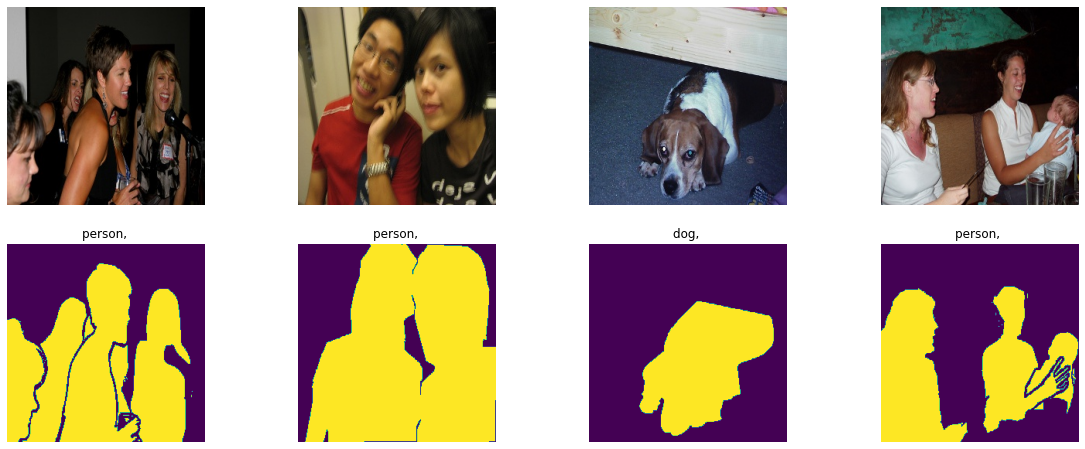

In [7]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_x)-1, size=4)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
  axs = fig.add_subplot(2,4,i+1)
  # Read image
  sample_input = cv2.imread(data_x[img_idx])
  plt.imshow(cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB))
  plt.axis('off')

  sample_mask = cv2.imread(data_y[img_idx])
  sample_mask = sample_mask[:,:,0]
  print("Mask Shape:",sample_mask.shape,"Classes:",np.unique(sample_mask))
  axs = fig.add_subplot(2,4,i+1+4)
  plt.imshow(sample_mask)
  plt.axis('off')

  title = ""
  for cls in np.unique(sample_mask):
    if cls > 0:
      title = title + index2label[cls] +", "
  axs.set_title(title)

plt.show()

In [8]:
# Find class counts
class_counts = dict((index, 0) for index, name in enumerate(label_names))

for y in data_y:
  mask = cv2.imread(y)
  mask = mask[:,:,0]
  for cls in np.unique(mask):
    class_counts[cls] = class_counts[cls] +1

print("Labels:", label2index)
print("Class Counts:",class_counts)

Labels: {'background': 0, 'aeroplane': 1, 'car': 2, 'cat': 3, 'dog': 4, 'person': 5}
Class Counts: {0: 991, 1: 91, 2: 142, 3: 216, 4: 186, 5: 498}


#### c) Explain how the data for the mask files are stored 

Hint: Analyze the content of `outputs` folder in your dataset 

##### **Submission:** 

Each input file has a corresponding output file of the same size as the input. Instead of each pixel storing a [R,B,G] value, it instead holds the class of what's at that pixel. The value at a pixel is the index of the contents of that pixel in this list of classes label_names = ['background', 'aeroplane', 'car', 'cat', 'dog', 'person'], so a background pixel is [0] and a cat is [3]

#### Build Data Pipelines

In [9]:
validation_percent = 0.15

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 842
validate_x count: 149


In [15]:
image_width = 224
image_height = 224
num_channels = 3
num_output_masks = num_classes
batch_size = 4
train_buffer_size=800
validation_buffer_size=200

# Load Image
def load_image(input_path, mask_path):
  # Input image
  input_image = tf.io.read_file(input_path)
  input_image = tf.image.decode_jpeg(input_image, channels=num_channels)
  
  # Mask image
  mask_image = tf.io.read_file(mask_path)
  mask_image = tf.image.decode_png(mask_image, channels=1)

  # Random cropping
  crop_x = np.random.randint(256 - image_width)
  crop_y = np.random.randint(256 - image_height)
  input_image = input_image[crop_y:crop_y+image_height, crop_x:crop_x+image_width]
  mask_image = mask_image[crop_y:crop_y+image_height, crop_x:crop_x+image_width]
  mask_image = tf.cast(mask_image, tf.float32)

  # Random Flipping
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    mask_image = tf.image.flip_left_right(mask_image)
  
  return input_image, mask_image

# Scale pixels
def scale_image_pixels(input_image, mask_image):
  input_image = tf.cast(input_image, tf.float32)
  input_image = input_image/127.5
  input_image -= 1.
  return input_image, mask_image

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(scale_image_pixels, num_parallel_calls=AUTOTUNE)
train_data = train_data.shuffle(buffer_size=train_buffer_size)
train_data = train_data.batch(batch_size)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(scale_image_pixels, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.shuffle(buffer_size=validation_buffer_size)
validation_data = validation_data.batch(batch_size)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <BatchDataset shapes: ((None, None, None, 3), (None, None, None, 1)), types: (tf.float32, tf.float32)>
validation_data <BatchDataset shapes: ((None, None, None, 3), (None, None, None, 1)), types: (tf.float32, tf.float32)>


In [16]:
# Taking which Semantic Segmentation with Transfer Learning Demo
def evaluate_model(model,test_data, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print("Evaluation Results:", evaluation_results)

---

## Question 2 : Train Semantic Segmentation Model from Scratch (1.5 Point)

#### a) Train a model without transfer learning

- Build a Semantic Segmentation Model. Ensure that the model is built without transfer learning.
- Ensure there is a plot of your training history

In [17]:

# Model input
input_shape = [image_height, image_width, num_channels] # height, width, channels

# Load the model architecture without randomized weights
tranfer_model_base = keras.applications.MobileNetV2(input_shape=input_shape, weights=None, include_top=False)
conv0 = tranfer_model_base.get_layer("expanded_conv_project").output # 112 x 112
conv1 = tranfer_model_base.get_layer("block_2_project").output # 56 x 56
conv2 = tranfer_model_base.get_layer("block_5_project").output # 28 x 28
conv3 = tranfer_model_base.get_layer("block_12_project").output # 14 x 14

up6 = tranfer_model_base.output 
conv7 = up6

up8 = layers.concatenate([layers.UpSampling2D()(conv7), conv3], axis=-1)
conv8 = layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same',activation='relu',name='conv8_1_3x3')(up8)

up9 = layers.concatenate([layers.UpSampling2D()(conv8), conv2], axis=-1)
conv9 = layers.Conv2D(filters=64,kernel_size=(3, 3),padding='same',activation='relu',name='conv9_1_3x3')(up9)

up10 = layers.concatenate([layers.UpSampling2D()(conv9), conv1], axis=-1)
conv10 = layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv10_1_3x3')(up10)

up11 = layers.concatenate([layers.UpSampling2D()(conv10), conv0], axis=-1)
conv11 = layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv11_1_3x3')(up11)

up12 = layers.UpSampling2D()(conv11)
conv12 = layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv12_1_3x3')(up12)

# Output Layer
output = layers.Conv2D(filters=num_output_masks,kernel_size=(1, 1), activation="softmax", name="prediction")(conv12)
#output = layers.Activation("softmax")(output)

# Build model
model = Model(inputs=tranfer_model_base.input, outputs=[output], name='fcn_mobilenet_'+str(int(time.time())))

model.summary()

Model: "fcn_mobilenet_1603148065"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
___________________________________________________________________________

Epoch 1/10
211/211 [==============================] - 12s 56ms/step - loss: 1.1562 - accuracy: 0.6342 - val_loss: 1.6001 - val_accuracy: 0.6426
Epoch 2/10
211/211 [==============================] - 11s 54ms/step - loss: 1.0775 - accuracy: 0.6416 - val_loss: 1.5276 - val_accuracy: 0.6426
Epoch 3/10
211/211 [==============================] - 12s 55ms/step - loss: 1.0439 - accuracy: 0.6412 - val_loss: 1.4957 - val_accuracy: 0.6426
Epoch 4/10
211/211 [==============================] - 12s 55ms/step - loss: 1.0202 - accuracy: 0.6463 - val_loss: 1.5091 - val_accuracy: 0.6426
Epoch 5/10
211/211 [==============================] - 11s 54ms/step - loss: 0.9873 - accuracy: 0.6530 - val_loss: 1.3526 - val_accuracy: 0.6426
Epoch 6/10
211/211 [==============================] - 11s 54ms/step - loss: 0.9977 - accuracy: 0.6512 - val_loss: 1.4415 - val_accuracy: 0.6043
Epoch 7/10
211/211 [==============================] - 11s 54ms/step - loss: 0.9746 - accuracy: 0.6547 - val_loss: 1.2991 - val_accuracy:

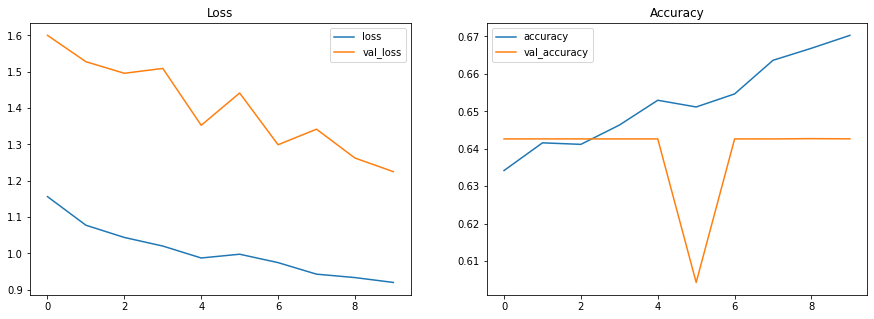

38/38 [==============================] - 0s 12ms/step - loss: 1.2256 - accuracy: 0.6426
Evaluation Results: [1.2255964279174805, 0.6426467299461365]


In [18]:
learning_rate = 0.001
epochs = 10

# Free up memory
K.clear_session()


# Optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = losses.SparseCategoricalCrossentropy()


# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluate_model(model,validation_data, training_results)

#### b) View results from model

## View Results


Classes to detect, with corresponding colors:


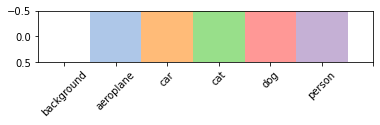

In [19]:
cmap_ref = cm.get_cmap('tab20', 12)
cmap_seg = np.zeros((6, 4))
cmap_seg[0] = [0.7, 0.7, 0.7, 0]
for i in range(1, 6):
  cmap_seg[i] = cmap_ref(i)

cmap_seg = ListedColormap(cmap_seg)
print("\nClasses to detect, with corresponding colors:")
plt.imshow([[0, 1, 2, 3, 4, 5]], cmap=cmap_seg)
plt.xticks([0,1 ,2 ,3 ,4 ,5, 6], label_names, rotation=45)
plt.show()

def preprocess_prediction_image(file_path):
  # Read image
  image = cv2.imread(file_path)
  # convert to rgb
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Reshape
  #image = cv2.resize(image, (image_height, image_width), interpolation=cv2.INTER_AREA)
  crop_x = (image.shape[1] - image_width) // 2
  crop_y = (image.shape[0] - image_height) // 2
  image = image[crop_y:crop_y+image_height, crop_x:crop_x+image_width]
  # Scale pixel
  image = image.astype(np.float32)
  image /= 127.5
  image -= 1.

  return image

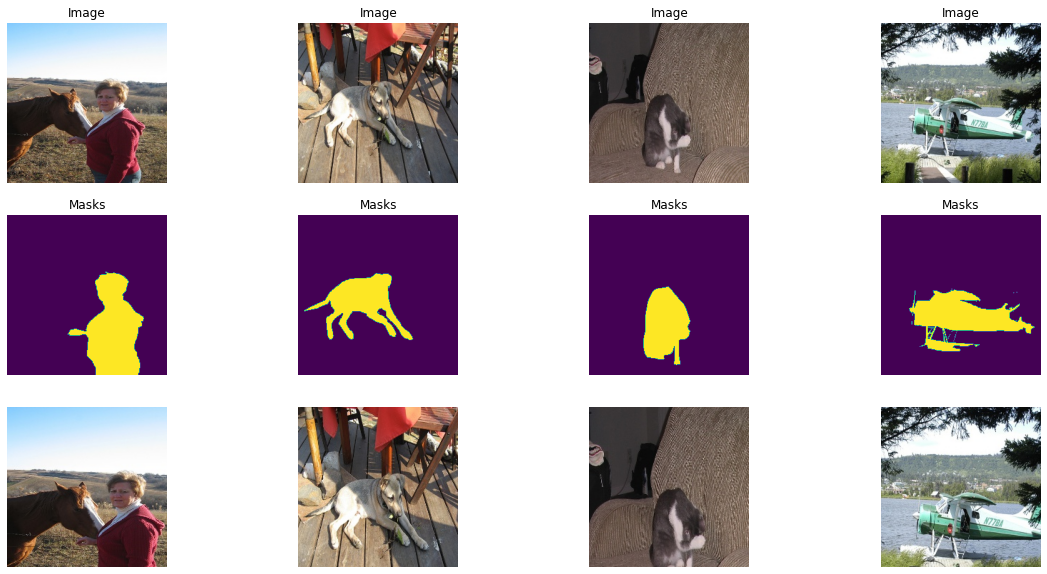

In [20]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(validate_x)-1, size=4)

fig = plt.figure(figsize=(20,10))
for i,img_idx in enumerate(image_samples):
  axs = fig.add_subplot(3,4,i+1)
  # Read image
  sample_input = cv2.imread(validate_x[img_idx])
  plt.imshow(cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  axs.set_title("Image")

  sample_mask = cv2.imread(validate_y[img_idx])
  sample_mask = sample_mask[:,:,0]
  axs = fig.add_subplot(3,4,i+1+4)
  plt.imshow(sample_mask)
  plt.axis('off')
  axs.set_title("Masks")

  axs = fig.add_subplot(3,4,i+1+8)
  plt.imshow(cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB))
  plt.axis('off')

  predict_x = [preprocess_prediction_image(validate_x[img_idx])]
  predict_x = np.asarray(predict_x)
  # Make predictions
  predictions = model.predict(predict_x)

  sample_pred = predictions[0]
  # Generate mask outputs
  pred_mask = tf.argmax(sample_pred, axis=-1)
  plt.imshow(pred_mask, cmap=cmap_seg, vmin=0, vmax=num_output_masks, alpha=0.6)

  title = ""
  for cls in np.unique(pred_mask):
    if cls > 0:
      title = title + index2label[cls] +", "
  axs.set_title(title)

plt.show()

#### c) Explain why this model is performing poorly


##### **Submission:** 

My notion here is that given the limited size of our dataset, the task of semantic segmentation is really difficult without transfer learning. Our model needs to learn to not only detect objects, but detect their boundaries. Additionally, as we saw with the example of the ship in the lecture slides that it's hard to train strictly on the segmentation as the loss doesn't necessary incentivize object detection. Thus, using a pretrained classification model and modifying training the decoder.

---

## Question 3 : Train Semantic Segmentation Model with Transfer Learning (2.5 Point)

#### a) Train model with transfer learning

- Build a Semantic Segmentation Model but this time with transfer learning.
- Ensure there is a plot of your training history
- Your baseline loss for the models should be a **Validation Loss** less than 0.45

In [21]:

# Model input
input_shape = [image_height, image_width, num_channels] # height, width, channels

# Load the model architecture without randomized weights
tranfer_model_base = keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)
tranfer_model_base.trainable = False
conv0 = tranfer_model_base.get_layer("expanded_conv_project").output # 112 x 112
conv1 = tranfer_model_base.get_layer("block_2_project").output # 56 x 56
conv2 = tranfer_model_base.get_layer("block_5_project").output # 28 x 28
conv3 = tranfer_model_base.get_layer("block_12_project").output # 14 x 14

up6 = tranfer_model_base.output 
conv7 = up6

up8 = layers.concatenate([layers.UpSampling2D()(conv7), conv3], axis=-1)
conv8 = layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same',activation='relu',name='conv8_1_3x3')(up8)

up9 = layers.concatenate([layers.UpSampling2D()(conv8), conv2], axis=-1)
conv9 = layers.Conv2D(filters=64,kernel_size=(3, 3),padding='same',activation='relu',name='conv9_1_3x3')(up9)

up10 = layers.concatenate([layers.UpSampling2D()(conv9), conv1], axis=-1)
conv10 = layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv10_1_3x3')(up10)

up11 = layers.concatenate([layers.UpSampling2D()(conv10), conv0], axis=-1)
conv11 = layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv11_1_3x3')(up11)

up12 = layers.UpSampling2D()(conv11)
conv12 = layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv12_1_3x3')(up12)

# Output Layer
output = layers.Conv2D(filters=num_output_masks,kernel_size=(1, 1), activation="softmax", name="prediction")(conv12)
#output = layers.Activation("softmax")(output)

# Build model
model = Model(inputs=tranfer_model_base.input, outputs=[output], name='fcn_mobilenet_'+str(int(time.time())))

model.summary()

Model: "fcn_mobilenet_1603148206"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
___________________________________________________________________________

Epoch 1/10
211/211 [==============================] - 6s 29ms/step - loss: 0.2550 - accuracy: 0.8987 - val_loss: 0.4575 - val_accuracy: 0.8495
Epoch 2/10
211/211 [==============================] - 5s 26ms/step - loss: 0.2380 - accuracy: 0.9079 - val_loss: 0.4475 - val_accuracy: 0.8497
Epoch 3/10
211/211 [==============================] - 5s 26ms/step - loss: 0.2424 - accuracy: 0.9071 - val_loss: 0.4472 - val_accuracy: 0.8577
Epoch 4/10
211/211 [==============================] - 5s 26ms/step - loss: 0.2135 - accuracy: 0.9152 - val_loss: 0.4203 - val_accuracy: 0.8590
Epoch 5/10
211/211 [==============================] - 5s 26ms/step - loss: 0.1913 - accuracy: 0.9237 - val_loss: 0.4315 - val_accuracy: 0.8637
Epoch 6/10
211/211 [==============================] - 6s 26ms/step - loss: 0.1963 - accuracy: 0.9219 - val_loss: 0.4306 - val_accuracy: 0.8597
Epoch 7/10
211/211 [==============================] - 6s 27ms/step - loss: 0.1855 - accuracy: 0.9273 - val_loss: 0.4733 - val_accuracy: 0.8564

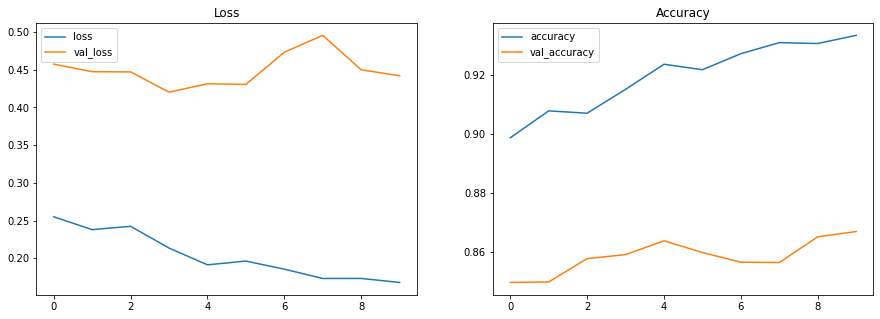

38/38 [==============================] - 0s 12ms/step - loss: 0.4542 - accuracy: 0.8623
Evaluation Results: [0.4541527032852173, 0.8623457551002502]


In [24]:
learning_rate = 0.001
epochs = 10

# Free up memory
K.clear_session()


# Optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Loss
loss = losses.SparseCategoricalCrossentropy()


# Compile
model.compile(loss=loss,
                  optimizer='Adam',
                  metrics=['accuracy'])
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluate_model(model,validation_data, training_results)

#### b) View results from model


Classes to detect, with corresponding colors:


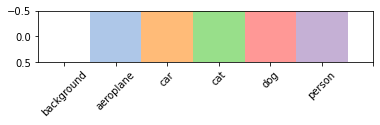

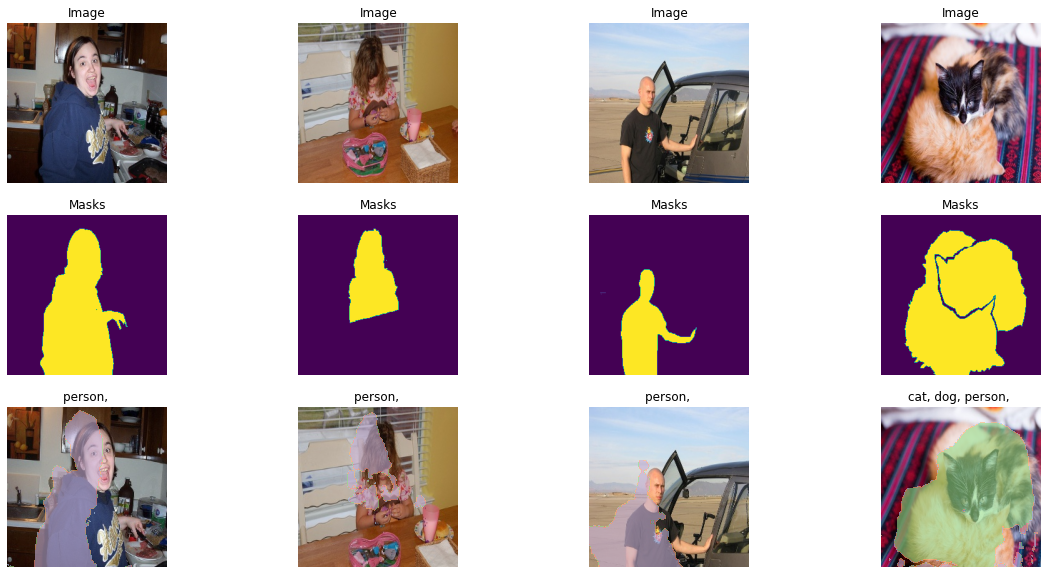

In [25]:
cmap_ref = cm.get_cmap('tab20', 12)
cmap_seg = np.zeros((6, 4))
cmap_seg[0] = [0.7, 0.7, 0.7, 0]
for i in range(1, 6):
  cmap_seg[i] = cmap_ref(i)

cmap_seg = ListedColormap(cmap_seg)
print("\nClasses to detect, with corresponding colors:")
plt.imshow([[0, 1, 2, 3, 4, 5]], cmap=cmap_seg)
plt.xticks([0,1 ,2 ,3 ,4 ,5, 6], label_names, rotation=45)
plt.show()

def preprocess_prediction_image(file_path):
  # Read image
  image = cv2.imread(file_path)
  # convert to rgb
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Reshape
  #image = cv2.resize(image, (image_height, image_width), interpolation=cv2.INTER_AREA)
  crop_x = (image.shape[1] - image_width) // 2
  crop_y = (image.shape[0] - image_height) // 2
  image = image[crop_y:crop_y+image_height, crop_x:crop_x+image_width]
  # Scale pixel
  image = image.astype(np.float32)
  image /= 127.5
  image -= 1.

  return image
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(validate_x)-1, size=4)

fig = plt.figure(figsize=(20,10))
for i,img_idx in enumerate(image_samples):
  axs = fig.add_subplot(3,4,i+1)
  # Read image
  sample_input = cv2.imread(validate_x[img_idx])
  plt.imshow(cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  axs.set_title("Image")

  sample_mask = cv2.imread(validate_y[img_idx])
  sample_mask = sample_mask[:,:,0]
  axs = fig.add_subplot(3,4,i+1+4)
  plt.imshow(sample_mask)
  plt.axis('off')
  axs.set_title("Masks")

  axs = fig.add_subplot(3,4,i+1+8)
  plt.imshow(cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB))
  plt.axis('off')

  predict_x = [preprocess_prediction_image(validate_x[img_idx])]
  predict_x = np.asarray(predict_x)
  # Make predictions
  predictions = model.predict(predict_x)

  sample_pred = predictions[0]
  # Generate mask outputs
  pred_mask = tf.argmax(sample_pred, axis=-1)
  plt.imshow(pred_mask, cmap=cmap_seg, vmin=0, vmax=num_output_masks, alpha=0.6)

  title = ""
  for cls in np.unique(pred_mask):
    if cls > 0:
      title = title + index2label[cls] +", "
  axs.set_title(title)

plt.show()

#### c) Explain why this model is doing a "good job" on semantic segmentation

##### **Submission:** 

In thise case, the model is doing a better job since the model is retrained to identify the objects in the image, and therefore the task of semantic segmentation is much easier than starting from scratch. 

#### d) Improve model performance

The dataset is small for this problem and there are a few techniques you could use to further improve model performance. Try a few from this list to see if you can lower your validation loss:
- Change Optimizer, learning rate, loss function etc.
- Using a Learning rate scheduler
- Using Early Stopping to stop training
- Add more data augmentation
- Or any other parameter or metric that works for you

What was the lowest validation loss you were able to achieve? And what techniques did you use and what helped and what did not? (2-3 sentences)

In [27]:
image_width = 224
image_height = 224
num_channels = 3
num_output_masks = num_classes
batch_size = 4
train_buffer_size=800
validation_buffer_size=200
aug_train_x = train_x + train_x + train_x
aug_train_y = train_y + train_y + train_y
# augmented = aug_pipeline(image=np.array(aug_train_x), mask=np.array(aug_train_y))

# Load Image
def load_image(input_path, mask_path):
  # Input image
  input_image = tf.io.read_file(input_path)
  input_image = tf.image.decode_jpeg(input_image, channels=num_channels)
  
  # Mask image
  mask_image = tf.io.read_file(mask_path)
  mask_image = tf.image.decode_png(mask_image, channels=1)

  # Random cropping
  crop_x = np.random.randint(256 - image_width)
  crop_y = np.random.randint(256 - image_height)
  input_image = input_image[crop_y:crop_y+image_height, crop_x:crop_x+image_width]
  mask_image = mask_image[crop_y:crop_y+image_height, crop_x:crop_x+image_width]
  mask_image = tf.cast(mask_image, tf.float32)

  # Random Flipping
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    mask_image = tf.image.flip_left_right(mask_image)
  
  return input_image, mask_image

def load_image_validation(input_path, mask_path):
  # Input image
  input_image = tf.io.read_file(input_path)
  input_image = tf.image.decode_jpeg(input_image, channels=num_channels)
  
  # Mask image
  mask_image = tf.io.read_file(mask_path)
  mask_image = tf.image.decode_png(mask_image, channels=1)
  
  return input_image, mask_image





# Scale pixels
def scale_image_pixels(input_image, mask_image):
  input_image = tf.cast(input_image, tf.float32)
  input_image = input_image/127.5
  input_image -= 1.
  return input_image, mask_image

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((aug_train_x, aug_train_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(scale_image_pixels, num_parallel_calls=AUTOTUNE)
train_data = train_data.shuffle(buffer_size=train_buffer_size)
train_data = train_data.batch(batch_size)



##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.map(load_image_validation, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(scale_image_pixels, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.shuffle(buffer_size=validation_buffer_size)
validation_data = validation_data.batch(batch_size)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <BatchDataset shapes: ((None, None, None, 3), (None, None, None, 1)), types: (tf.float32, tf.float32)>
validation_data <BatchDataset shapes: ((None, None, None, 3), (None, None, None, 1)), types: (tf.float32, tf.uint8)>


##### **Submission:** 
Using the following strategies I was able to achieve a validation loss of 0.3635

* Using callbacks to decrease learning rate when validation loss is no longer improving. This is done via the code from the in-class demo
* Data augmentation. The training dataset is really small. I've dupicated each image 4 times and applied the same random cropping and flipping that was done before to this increased dataset. I've also made it so there are no modifications to the validation data. It doesn't make sense to apply random cropping and flipping to the validation data, as this tactic should only aid in the training of the model.
* Early stopping -- I stop the model early if loss does not improve after 3 interations. This mostly helps with training time, but is an improvement.


Epoch 1/20
632/632 [==============================] - 18s 28ms/step - loss: 0.5595 - accuracy: 0.7854 - val_loss: 0.3992 - val_accuracy: 0.8444
Epoch 2/20
632/632 [==============================] - 17s 28ms/step - loss: 0.3196 - accuracy: 0.8713 - val_loss: 0.3545 - val_accuracy: 0.8649
Epoch 3/20
632/632 [==============================] - 18s 28ms/step - loss: 0.2590 - accuracy: 0.8972 - val_loss: 0.3826 - val_accuracy: 0.8688
Epoch 4/20
632/632 [==============================] - 18s 28ms/step - loss: 0.2247 - accuracy: 0.9107 - val_loss: 0.3957 - val_accuracy: 0.8659
Epoch 5/20
632/632 [==============================] - 17s 27ms/step - loss: 0.1907 - accuracy: 0.9239 - val_loss: 0.3635 - val_accuracy: 0.8780
Training execution time (mins) 1.6198984940846761


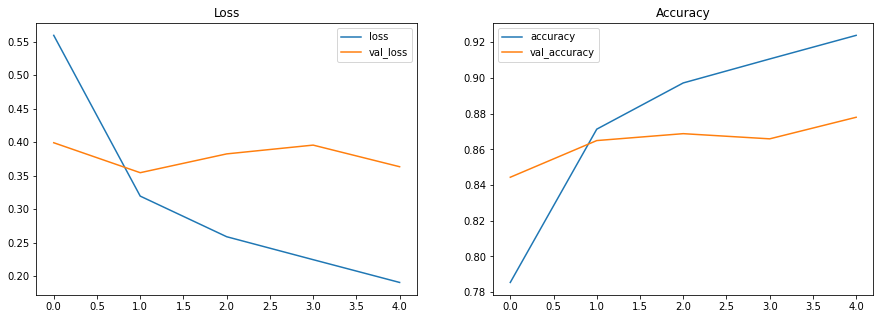

38/38 [==============================] - 1s 14ms/step - loss: 0.3635 - accuracy: 0.8780
Evaluation Results: [0.36345991492271423, 0.8779881596565247]


In [29]:

# Model input
input_shape = [image_height, image_width, num_channels] # height, width, channels

# Load the model architecture without randomized weights
tranfer_model_base = keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)
tranfer_model_base.trainable = False
conv0 = tranfer_model_base.get_layer("expanded_conv_project").output # 112 x 112
conv1 = tranfer_model_base.get_layer("block_2_project").output # 56 x 56
conv2 = tranfer_model_base.get_layer("block_5_project").output # 28 x 28
conv3 = tranfer_model_base.get_layer("block_12_project").output # 14 x 14

up6 = tranfer_model_base.output 
conv7 = up6

up8 = layers.concatenate([layers.UpSampling2D()(conv7), conv3], axis=-1)
conv8 = layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same',activation='relu',name='conv8_1_3x3')(up8)

up9 = layers.concatenate([layers.UpSampling2D()(conv8), conv2], axis=-1)
conv9 = layers.Conv2D(filters=64,kernel_size=(3, 3),padding='same',activation='relu',name='conv9_1_3x3')(up9)

up10 = layers.concatenate([layers.UpSampling2D()(conv9), conv1], axis=-1)
conv10 = layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv10_1_3x3')(up10)

up11 = layers.concatenate([layers.UpSampling2D()(conv10), conv0], axis=-1)
conv11 = layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv11_1_3x3')(up11)

up12 = layers.UpSampling2D()(conv11)
conv12 = layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv12_1_3x3')(up12)

# Output Layer
output = layers.Conv2D(filters=num_output_masks,kernel_size=(1, 1), activation="softmax", name="prediction")(conv12)
#output = layers.Activation("softmax")(output)

# Build model
model = Model(inputs=tranfer_model_base.input, outputs=[output], name='fcn_mobilenet_'+str(int(time.time())))

# model.summary()
learning_rate = 0.1
epochs = 20

# Free up memory
K.clear_session()


# Optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Callbacks
# Learning Rate Scheduler: Change learning rates during training epochs
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * 0.01
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
# Early Stopping: Stop training when a monitored metric has stopped improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto'
)
callbacks = [lr_scheduler,early_stopping]



# Loss
loss = losses.SparseCategoricalCrossentropy()


# Compile
model.compile(loss=loss,
                  optimizer='Adam',
                  metrics=['accuracy'])
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluate_model(model,validation_data, training_results)

In [ ]:
tf.enable_eager_execution()